In [2]:
#imports
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [3]:
#store csvs in memory

normalized_folder = "../processed_data_normalized"
all_files = glob.glob(f"{normalized_folder}/*.csv")

dfs = [pd.read_csv(f) for f in all_files]
df_all = pd.concat(dfs, ignore_index=True)


In [6]:
features = ['total','lighting','cooling','heating','luxuries','necessities','water',
            'temperature','humidity','month_cos','half_day_cos','in.occupants','in.sqft',
            'total_rolling_mean','total_rolling_std']


In [ ]:
seq_len = 14  # 14 rows = 7 days

X, y = [], []

for b_id in df_all['building_id'].unique():
    df_b = df_all[df_all['building_id'] == b_id].reset_index(drop=True)
    
    for i in range(len(df_b) - seq_len):
        X.append(df_b.loc[i:i+seq_len-1, features].values)
        y.append(df_b.loc[i+seq_len, 'total'])

X = np.array(X) 
y = np.array(y)  


In [8]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (142416, 14, 15)
y shape: (142416,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

num_features = X.shape[2]  


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Dropout, RepeatVector, TimeDistributed
)
from tensorflow.keras.regularizers import l2

timesteps = X.shape[1]
n_features = X.shape[2]

inputs = Input(shape=(timesteps, n_features))
x = TimeDistributed(Dense(128, activation="relu"))(inputs)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dense(32, activation="relu", kernel_regularizer=l2(1e-4))(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="mse")
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 14, 128)        │         2,048 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y = np.array(y) 
print(y.shape)


(142416,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_total = MinMaxScaler()
y_scaled = scaler_total.fit_transform(y.reshape(-1, 1)) 

In [ ]:
y_scaled = scaler_total.fit_transform(y.reshape(-1, 1))  

history = model.fit(
    X, y_scaled,                
    epochs=50,
    batch_size=128,
    validation_split=0.25,
    shuffle=True
)


Epoch 1/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 2/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 3/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 5/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 9.0057e-04 - val_loss: 9.5025e-04
Epoch 7/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 8.1159e-04 - val_loss: 9.9462e-04
Epoch 8/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 7.4933e-04 - val_loss: 8.9714e-04
Epoch 9/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 7.1890e-04 - val_loss: 8.1300e-04
Epoch 10/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 6.8879e-04 - val_loss: 8.1045e-04
Epoch 11/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 6.7851e-04 - val

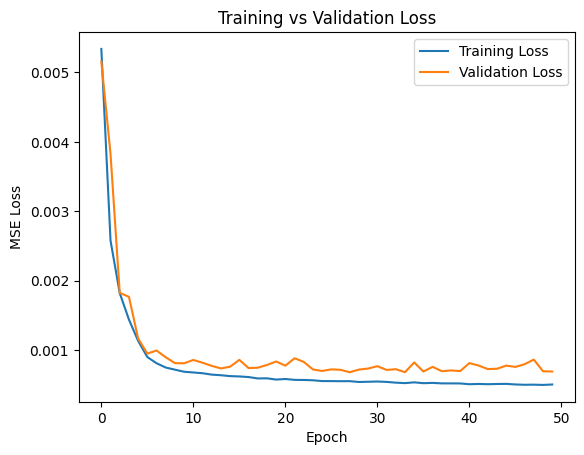

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
model.save("model2.keras")